In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

In [2]:
root_path = 'audio/'

In [3]:
audio_path = root_path + "mvmt 2.mp3"
offset = 0.2
dur = 15
y, sr = librosa.load(audio_path, sr=41000, duration=dur, offset=offset)

ipd.Audio(y, rate=sr)

c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


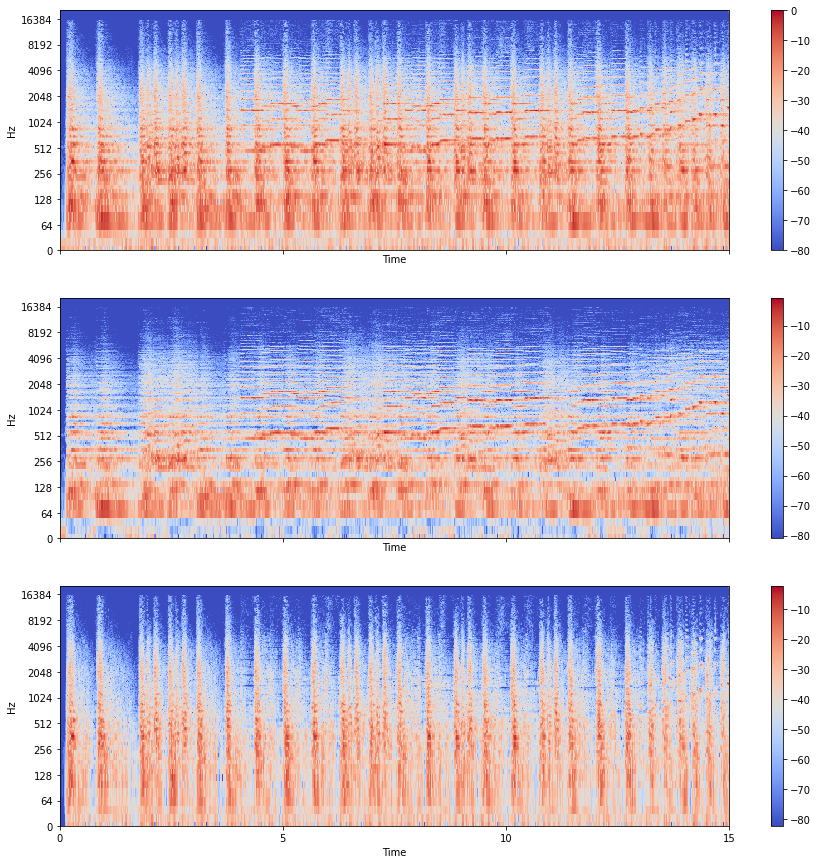

In [4]:
# Short-term Fourier Transform: Highlights intensities of different frequencies over time
# Note: Hz is in log scale
X = librosa.stft(y)
H, P = librosa.decompose.hpss(X)
Xdb = librosa.amplitude_to_db(np.abs(X), ref=np.max)
Hdb = librosa.amplitude_to_db(np.abs(H), ref=np.max(np.abs(X)))
Pdb = librosa.amplitude_to_db(np.abs(P), ref=np.max(np.abs(X)))

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(15, 15))

img1 = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log', ax=ax[0], cmap='coolwarm')
img2 = librosa.display.specshow(Hdb, sr=sr, x_axis='time', y_axis='log', ax=ax[1], cmap='coolwarm')
img3 = librosa.display.specshow(Pdb, sr=sr, x_axis='time', y_axis='log', ax=ax[2], cmap='coolwarm')

fig.colorbar(mappable=img1, ax=ax[0])
fig.colorbar(mappable=img2, ax=ax[1])
fig.colorbar(mappable=img3, ax=ax[2])

In [5]:
# Get initial chromagram from librosa
def generate_chroma(y, sr, hop_length=256):
    # Filter and focus on harmonic frequencies
    y_harm = librosa.effects.harmonic(y=y, margin=16)
    chroma_harm = librosa.feature.chroma_stft(y_harm, sr=sr, hop_length=hop_length)

    # Do some de-noising by smoothing out over nearby frequencies
    return np.minimum(chroma_harm, librosa.decompose.nn_filter(chroma_harm, aggregate=np.median, metric='cosine'))

In [6]:
# Normalize note energies based on the other notes being played at that time
# Useful when peak energy can fluctuate (ex: based on dynamics)
import math

def peak_notes(chroma_arr, window_width, window_step):
    note_seq = np.empty((12, int(math.ceil(chroma_arr.shape[1] / window_step))))
    print("Window width:", window_width * 1 / (sr / hop_length), "sec")
    print("Window step:", window_step * 1 / (sr / hop_length), "sec")

    # Normalize based on notes in sliding window
    for i in range(0, chroma_arr.shape[1], window_step):
        # Get an estimate for the "length" of each note by summing how much energy
        # is in each note within the entire window
        sum_end = min(i+window_width, chroma_arr.shape[1])
        note_lengths = np.sum(chroma_arr[:, i:int(sum_end)], axis=1)

        # Normalize each "length" so maximum length is 1.0
        note_weights = note_lengths / np.max(note_lengths)
        note_seq[:, int(i/window_step)] = note_weights
    return note_seq

In [7]:
# Filter out notes that don't have a high intensity
def filt(chroma, threshold=0.8):
    filt = np.where(chroma > threshold, chroma, 0)
    return filt

In [8]:
# Generate chromagram
hop_length = 128

chroma_harm = generate_chroma(y, sr, hop_length=hop_length)
filt_harm = filt(chroma_harm)
chroma_peak = peak_notes(filt_harm, window_width=32, window_step=8)
filt_peak = filt(chroma_peak)

Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec


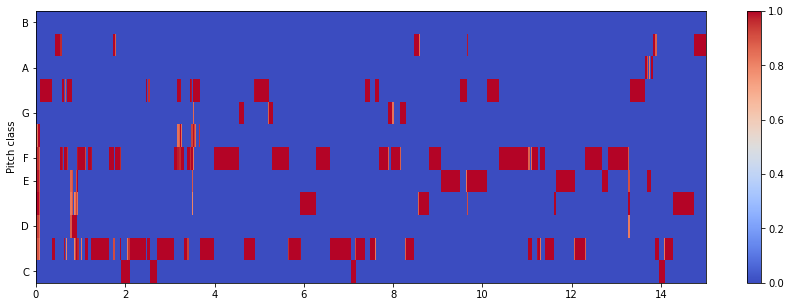

In [9]:
# Visualize chromagram
fig, ax = plt.subplots(figsize=(15, 5))
plt.pcolormesh(np.linspace(0, dur, num=filt_peak.shape[1]+1), np.linspace(0, 12, num=13), filt_peak, cmap='coolwarm')

librosa.display.__decorate_axis(ax.yaxis, "chroma")

plt.colorbar()

In [10]:
def find_dcsh_motif(frames, max_gap=64, note_threshold=0.8, offset=0, frame_per_sec=sr/hop_length):
    print(f"Max gap: {max_gap / frame_per_sec}")
    d_starts = []
    ds_transitions = []
    sc_transitions = []
    ch_transitions = []
    
    # Find individual transition points
    
    # Start of D
    i = 0
    while i < frames.shape[1]:
        if(frames[2][i] > note_threshold):
            d_starts.append(i)
            while i < frames.shape[1] and frames[2][i] > note_threshold:
                i+= 1
        i += 1
    
    # D - Eflat
    i = 0
    while i < frames.shape[1]:
        if(frames[2][i] > note_threshold):
            for j in range(max_gap):
                if(i + j < frames.shape[1] and frames[3][i+j] > note_threshold):
                    ds_transitions.append(i)
                    # Only count beginning of note, go until note ends
                    while i < frames.shape[1] and frames[2][i] > note_threshold:
                        i += 1
                    break
        i += 1
        
    # Eflat - C
    i = 0
    while i < frames.shape[1]:
        if(frames[3][i] > note_threshold):
            for j in range(max_gap):
                if(i + j < frames.shape[1] and frames[0][i+j] > note_threshold):
                    sc_transitions.append(i)
                    while i < frames.shape[1] and frames[3][i] > note_threshold:
                        i += 1
                    break
        i += 1
    
    # C - B
    i = 0
    while i < frames.shape[1]:
        if(frames[0][i] > note_threshold):
            for j in range(max_gap):
                if(i + j < frames.shape[1] and frames[11][i+j] > note_threshold):
                    ch_transitions.append(i)
                    while i < frames.shape[1] and frames[0][i] > note_threshold:
                        i += 1
                    break
        i += 1
    
    # Convert from frame to second
    d_starts = np.array(d_starts) / frame_per_sec + offset
    ds_transitions = np.array(ds_transitions) / frame_per_sec + offset
    sc_transitions = np.array(sc_transitions) / frame_per_sec + offset
    ch_transitions = np.array(ch_transitions) / frame_per_sec + offset
    
    # A valid DSCH motif is if the four transitions are in order, between 0.2sec - 2sec apart from each other
    dsch_motifs = [(0,0,0,0)]
    for d_start in d_starts:
        # We shouldn't have overlapping patterns
        if(d_start < dsch_motifs[-1][-1]): continue
        
        for ds_transition in ds_transitions:
            if not (0.2 <= ds_transition - d_start <= 2): continue

            for sc_transition in sc_transitions:
                if not (0.2 <= sc_transition - ds_transition <= 2): continue
                
                for ch_transition in ch_transitions:
                    if not (0.2 <= ch_transition - sc_transition <= 2): continue
                            
                    dsch_motifs.append((d_start, ds_transition, sc_transition, ch_transition))
                    # print(dsch_patterns[-1])
                    break
                else:
                    continue
                break
            else: 
                continue
            break
    return dsch_motifs[1:]

In [11]:
# Find DCSH pattern across entire mvmt
from mutagen.mp3 import MP3

def analyze_mvmt(audio_path):
    all_motifs = []
    
    audio_length = MP3(audio_path).info.length
    print(f"{audio_length} seconds")
    
    # Look at 60 second intervals at a time, overlapping by 5 seconds 
    # so we don't potentially miss a motif across two intervals
    dur = 60
    offset = 0
    hop_length = 128
    while offset < audio_length:
        print(f"Loading {offset} - {offset + dur}")
        y, sr = librosa.load(audio_path, sr=41000, duration=dur, offset=offset)
        
        chroma_harm = generate_chroma(y, sr, hop_length=hop_length)
        filt_harm = filt(chroma_harm)
        chroma_peak = peak_notes(filt_harm, window_width=32, window_step=8)
        filt_peak = filt(chroma_peak)
        
        seg_motifs = find_dcsh_motif(filt_peak, max_gap=8, offset=offset, frame_per_sec=sr/hop_length/8)
        print(f"In {offset} - {offset + dur}: {seg_motifs}")
        all_motifs = [*all_motifs, *seg_motifs]
        
        offset += dur - 5
    
    return all_motifs
    
all_motifs = analyze_mvmt(root_path + "mvmt 3.mp3")

724.4467120181406 seconds
Loading 0 - 60


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 0 - 60: [(0.0, 0.2997073170731707, 0.5994146341463414, 2.048), (2.048, 2.7972682926829266, 3.4965853658536585, 4.845268292682927), (21.578926829268294, 22.552975609756096, 23.726829268292683, 25.50009756097561), (25.674926829268294, 26.5990243902439, 28.07258536585366, 29.895804878048782)]
Loading 55 - 115


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 55 - 115: [(85.54517073170732, 85.7699512195122, 86.39434146341463, 86.7939512195122)]
Loading 110 - 170


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 110 - 170: [(145.41541463414634, 146.8140487804878, 148.38751219512196, 149.83609756097562), (151.45951219512196, 151.70926829268294, 152.83317073170733, 153.80721951219513)]
Loading 165 - 225


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 165 - 225: [(173.2669268292683, 174.1910243902439, 174.89034146341464, 175.4647804878049), (176.83843902439025, 178.81151219512196, 179.21112195121952, 180.13521951219514)]
Loading 220 - 280


C:\Users\cuian\AppData\Local\Temp/ipykernel_32588/803758367.py:18: RuntimeWarning: invalid value encountered in true_divide
  note_weights = note_lengths / np.max(note_lengths)
c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 220 - 280: [(264.30673170731706, 265.35570731707315, 266.8292682926829, 268.0780487804878)]
Loading 275 - 335


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 275 - 335: []
Loading 330 - 390


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 330 - 390: [(370.11082926829266, 371.9090731707317, 372.6833170731707, 373.6323902439024)]
Loading 385 - 445


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 385 - 445: [(389.1459512195122, 390.46965853658537, 391.0940487804878, 391.89326829268293), (392.5176585365854, 393.3668292682927, 393.59160975609757, 395.2899512195122), (406.5289756097561, 408.30224390243905, 408.6019512195122, 408.8267317073171), (409.10146341463417, 409.47609756097563, 410.42517073170734, 410.7998048780488), (410.8747317073171, 411.9736585365854, 412.24839024390246, 412.9227317073171)]
Loading 440 - 500


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 440 - 500: [(479.11180487804876, 479.36156097560973, 479.7611707317073, 480.13580487804876), (492.8983414634146, 493.1480975609756, 493.52273170731706, 493.8973658536585)]
Loading 495 - 555


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 495 - 555: [(503.3418536585366, 503.59160975609757, 503.91629268292684, 504.3159024390244), (528.1925853658537, 528.4423414634147, 528.8419512195122, 529.1666341463415)]
Loading 550 - 610


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 550 - 610: [(558.5666341463415, 559.9153170731707, 560.2150243902439, 560.4647804878049), (561.1640975609756, 562.5627317073171, 562.8374634146342, 563.0872195121951)]
Loading 605 - 665


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 605 - 665: [(648.1578536585366, 649.3067317073171, 650.1559024390244, 650.5055609756098), (656.3748292682927, 657.6485853658537, 659.2969756097561, 659.5717073170732)]
Loading 660 - 720


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 660 - 720: [(673.2120975609756, 674.3110243902439, 675.2101463414634, 675.7096585365854), (676.0343414634146, 676.2591219512195, 678.0074146341464, 679.456), (687.897756097561, 688.4971707317073, 689.9207804878049, 690.2954146341464), (690.3953170731708, 692.3933658536586, 694.3914146341464, 696.2146341463415), (710.9502439024391, 711.4247804878049, 712.1240975609757, 712.7734634146342), (713.9473170731708, 714.8963902439025, 716.4698536585366, 717.1192195121952)]
Loading 715 - 775


c:\users\cuian\documents\programming projects\fs63c_final\venv\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Window width: 0.09990243902439025 sec
Window step: 0.024975609756097562 sec
Max gap: 0.1998048780487805
In 715 - 775: [(715.0, 716.2987317073171, 717.1229268292683, 717.9720975609756), (722.0680975609756, 722.3428292682927, 722.8922926829268, 723.2419512195122)]


In [12]:
# Manually remove/add motif locations
all_motifs.append((70, 70.75, 71.5, 72))
all_motifs.append((99, 99.5, 100, 100.5))
all_motifs.append((105, 105.5, 106, 106.5))
all_motifs.append((123, 123.5, 124, 124.5))
all_motifs.append((204, 204.75, 205.5, 205))
all_motifs.append((476, 476.3, 476.6, 477))
all_motifs.append((561, 561.3, 561.6, 562))
all_motifs.append((562, 562.3, 562.6, 563))
all_motifs.append((563, 563.3, 563.6, 564))
all_motifs.append((572, 572.3, 572.6, 573))
all_motifs.append((581, 581.3, 581.6, 582))
all_motifs.append((603, 603.3, 603.6, 604))

all_motifs = [loc for loc in all_motifs if not (loc[0] <= 30 or 170 <= loc[0] <= 180 or 360 <= loc[0] <= 420)]
    
print("Found:")
for loc in all_motifs:
    print(str(loc) + ",")

Found:
(85.54517073170732, 85.7699512195122, 86.39434146341463, 86.7939512195122),
(145.41541463414634, 146.8140487804878, 148.38751219512196, 149.83609756097562),
(151.45951219512196, 151.70926829268294, 152.83317073170733, 153.80721951219513),
(264.30673170731706, 265.35570731707315, 266.8292682926829, 268.0780487804878),
(479.11180487804876, 479.36156097560973, 479.7611707317073, 480.13580487804876),
(492.8983414634146, 493.1480975609756, 493.52273170731706, 493.8973658536585),
(503.3418536585366, 503.59160975609757, 503.91629268292684, 504.3159024390244),
(528.1925853658537, 528.4423414634147, 528.8419512195122, 529.1666341463415),
(558.5666341463415, 559.9153170731707, 560.2150243902439, 560.4647804878049),
(561.1640975609756, 562.5627317073171, 562.8374634146342, 563.0872195121951),
(648.1578536585366, 649.3067317073171, 650.1559024390244, 650.5055609756098),
(656.3748292682927, 657.6485853658537, 659.2969756097561, 659.5717073170732),
(673.2120975609756, 674.3110243902439, 675.2